In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import numpy as np
import math
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import pathlib
import os
import dateutil.parser as parser
from datetime import datetime
from datetime import date
from dateutil.relativedelta import relativedelta
from sklearn.linear_model import LinearRegression
import plotly.express as px
import plotly.graph_objects as go
import tqdm
import statistics
import statsmodels.api as sm
from statsmodels.api import graphics
from statsmodels.graphics.plot_grids import scatter_ellipse
from statsmodels.stats.outliers_influence import variance_inflation_factor
from linearmodels import PanelOLS
from linearmodels import RandomEffects
import statsmodels.stats.api as sms
import sklearn
from sklearn import tree
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, ShuffleSplit
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor, AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import r2_score, zero_one_loss, mean_absolute_error
from sklearn.inspection import permutation_importance
from collections import defaultdict
import graphviz
import unicodedata
import IPython

# Define Functions

In [2]:
def vif(cont_vars, data):
    # VIF dataframe 
    vif_data = pd.DataFrame()
    vif_data["feature"] = cont_vars
  
    # calculating VIF for each feature 
    vif_data["VIF"] = [variance_inflation_factor(data[cont_vars].dropna().values, i) 
                          for i in range(len(cont_vars))] 
  
    print(vif_data)

In [140]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / abs(test_labels))
    accuracy = 100 - mape
    #accuracy_score = sklearn.metrics.accuracy_score(test_labels.astype(int), predictions)
    print('Model Performance')
    print('Mean Absolute Error: {:0.4f}'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    #print('Accuracy Score = {:0.4f}'.format(accuracy_score))
     
    return accuracy

In [128]:
def reg_tree(train= None, test= None, controls = None, perf= None, sector= None, type_tree = None, grid = False, params = None):
    data_help = None

    # making sure no inf or NaN values
    y_train = train[perf]
    y_test = test[perf]
    if sector != None:
        X_train = pd.concat([train[controls], train[sector]], axis = 1)
        X_test = pd.concat([test[controls], test[sector]], axis = 1)
    else:
        X_train = train[controls]
        X_test = test[controls]
        
    z_train = pd.concat([y_train, X_train], axis = 1)
    z_test = pd.concat([y_test, X_test], axis = 1)
    
    z_train.replace([np.inf, -np.inf], np.nan,inplace=True)
    z_test.replace([np.inf, -np.inf], np.nan,inplace=True)
    
    z_train = z_train.dropna()
    z_test = z_test.dropna()
    
    y_train = z_train[perf]
    y_test = z_test[perf]
    
    if sector != None:
        X_train = pd.concat([z_train[controls], z_train[sector]], axis = 1)
        X_test = pd.concat([z_test[controls], z_test[sector]], axis = 1)
    else:
        X_train = z_train[controls]
        X_test = z_test[controls]
    
    names = X_train.columns
    
    # traing regression tree
    # GradientBoost
    if type_tree == 'gradboost':
        if grid:
            calibrated_boost = GradientBoostingRegressor()
            param_grid = {'loss': ['ls', 'lad', 'huber', 'quantile'], 'n_estimators':[10,20,50,100,200], 'learning_rate':[0.01,0.05,0.1,0.3,0.5,1], 'max_depth':[1, 3, 6, 9], 'min_samples_split':[10, 20, 30]}
            clf = GridSearchCV(calibrated_boost, param_grid, cv=5, verbose = 2, n_jobs=-1)
        else:
            clf = GradientBoostingRegressor(**params)
    if type_tree == 'gradboost class':
        if grid:
            calibrated_boost = GradientBoostingClassifier()
            param_grid = {'loss': ['deviance', 'exponential'], 'n_estimators':[10,20,50,100,200], 'learning_rate':[0.01,0.05,0.1,0.3,0.5,1], 'max_depth':[1, 3, 6, 9], 'min_samples_split':[10, 20, 30]}
            clf = GridSearchCV(calibrated_boost, param_grid, cv=5, verbose = 2, n_jobs=-1)
        else:
            clf = GradientBoostingClassifier(**params)
    
    # AdaBoost
    elif type_tree == 'adaboost':
        if grid:
            calibrated_boost = AdaBoostRegressor(tree.DecisionTreeRegressor())
            param_grid = {'loss': ['linear', 'square', 'exponential'], 'n_estimators':[10,20,50,100,200], 'learning_rate':[0.01,0.05,0.1,0.3,0.5,1], 'base_estimator__max_depth':[1,3,6,9], 'base_estimator__min_samples_split':[10, 20, 30]}
            clf = GridSearchCV(calibrated_boost, param_grid, cv=5, verbose = 2, n_jobs=-1)
        else:
            clf = AdaBoostRegressor(tree.DecisionTreeRegressor())
            clf.set_params(**params)
    elif type_tree == 'adaboost class':
        if grid:
            calibrated_boost = AdaBoostClassifier(tree.DecisionTreeClassifier()) # alogithm': ['SAMME', 'SAMME.R'],
            param_grid = {'n_estimators':[10,20,50,100,200], 'learning_rate':[0.01,0.05,0.1,0.3,0.5,1], 'base_estimator__max_depth':[1,3,6,9], 'base_estimator__min_samples_split':[10, 20, 30]}
            clf = GridSearchCV(calibrated_boost, param_grid, cv=5, verbose = 2, n_jobs=-1)
        else:
            clf = AdaBoostClassifier(tree.DecisionTreeClassifier())
            clf.set_params(**params)
    
    # Random Forest
    elif type_tree == 'forest':
        if grid:
            calibrated_forest = RandomForestRegressor()
            param_grid = {'n_estimators':[10,20,50,100,200,500], 'max_depth':[2, 5, 10, 15, 20], 'min_samples_split':[10, 20, 30], 'min_samples_leaf':[2,10,20], 'max_features': ['auto', 'sqrt'], 'ccp_alpha': [0.001,0.01,0.02]}
            clf = GridSearchCV(calibrated_forest, param_grid, cv=5, verbose = 2, n_jobs=-1)
            
        else:
            clf = RandomForestRegressor(**params)
    elif type_tree == 'forest class':
        if grid:
            calibrated_forest = RandomForestClassifier()
            param_grid = {'n_estimators':[10,20,50,100,200,500], 'max_depth':[2, 5, 10, 15, 20], 'min_samples_split':[10, 20, 30], 'min_samples_leaf':[2,10,20], 'max_features': ['auto', 'sqrt'], 'ccp_alpha': [0.001,0.01,0.02]}
            #param_grid = {'max_depth':[1,2], 'min_samples_split':[10, 20], 'min_samples_leaf':[2,5,10]}
            clf = GridSearchCV(calibrated_forest, param_grid, cv=5, verbose = 2, n_jobs=-1)
            
        else:
            clf = RandomForestClassifier(**params)
    
    # Decision Tree
    elif type_tree == 'tree':
        if grid:
            clf = tree.DecisionTreeRegressor()
            parameters = {'max_depth':[1,2,3,4,5,6,7,8,9,10], 'min_samples_split':[10, 20], 'min_samples_leaf':[2,5,10]}
            clf = GridSearchCV(clf, parameters, 'r2', refit='r2', verbose = 2, n_jobs=-1)
        else:
            clf = tree.DecisionTreeRegressor(max_depth = 5, min_samples_split = 10, min_samples_leaf = 2)
    elif type_tree == 'tree class':
        if grid:
            clf = tree.DecisionTreeClassifier()
            parameters = {'max_depth':[1,2,3,4,5,6,7,8,9,10], 'min_samples_split':[10, 20], 'min_samples_leaf':[2,5,10]}
            clf = GridSearchCV(clf, parameters, 'r2', refit='r2', verbose = 2, n_jobs=-1)
        else:
            clf = tree.DecisionTreeClassifier(max_depth = 5, min_samples_split = 10, min_samples_leaf = 2)
    
    #evaluation
    y_train = np.ravel(y_train)
    y_test = np.ravel(y_test)
    if grid:
        clf.fit(X_train, y_train)
        score = clf.best_score_
        best_random = clf.best_estimator_
    else:                                                 
        score = cross_val_score(clf, X_train, y_train, cv=10, scoring = 'r2')
        clf.fit(X_train, y_train)
        best_random = clf
    
    random_accuracy = evaluate(best_random, X_test, y_test)

    
    if type_tree == 'adaboost':        
        train_score = np.zeros((best_random.n_estimators,))
        for i, y_pred in enumerate(best_random.staged_predict(X_train)):
            train_score[i] = mean_absolute_error(y_pred, y_train)
            
        test_score = np.zeros((best_random.n_estimators,))
        for i, y_pred in enumerate(best_random.staged_predict(X_test)):
            test_score[i] = mean_absolute_error(y_pred, y_test)
        
        fig = plt.figure(figsize=(6, 6))
        plt.subplot(1, 1, 1)
        plt.title('Deviance')
        plt.plot(np.arange(best_random.n_estimators) + 1, train_score, 'b-', label='Training Set Deviance')
        plt.plot(np.arange(best_random.n_estimators) + 1, test_score, 'r-', label='Test Set Deviance')
        plt.legend(loc='upper right')
        plt.xlabel('Boosting Iterations')
        plt.ylabel('Mean Absolute Error')
        fig.tight_layout()
        plt.show()

    if type_tree == 'gradboost':
        test_score = np.zeros((best_random.n_estimators,), dtype=np.float64)
        for i, y_pred in enumerate(best_random.staged_predict(X_test)):
            test_score[i] = best_random.loss_(y_test, y_pred)

        fig = plt.figure(figsize=(6, 6))
        plt.subplot(1, 1, 1)
        plt.title('Deviance')
        plt.plot(np.arange(best_random.n_estimators) + 1, best_random.train_score_, 'b-', label='Training Set Deviance')
        plt.plot(np.arange(best_random.n_estimators) + 1, test_score, 'r-', label='Test Set Deviance')
        plt.legend(loc='upper right')
        plt.xlabel('Boosting Iterations')
        plt.ylabel('Deviance')
        fig.tight_layout()
        plt.show()
    
    feature_importance = best_random.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    fig = plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, np.array(names)[sorted_idx])
    plt.title('Feature Importance (MDI)')

    result = permutation_importance(best_random, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
    sorted_idx = result.importances_mean.argsort()
    plt.subplot(1, 2, 2)
    plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=np.array(names)[sorted_idx])
    plt.title("Permutation Importance (test set) (MDA)")
    fig.tight_layout()
    plt.show()
    
    print("Features sorted by their mean decrease impurity:")
    print(sorted(zip(map(lambda x: round(x, 4), best_random.feature_importances_), names), reverse=True))
    
    scores = defaultdict(list)  
    
    #crossvalidate the scores on a number of different random splits of the training data
    for j in range(5):
        X_train2, X_test, Y_train2, Y_test = train_test_split(X_train, y_train, test_size=0.33, random_state=j)
        rf = best_random.fit(X_train2, Y_train2)
        acc = r2_score(Y_test, rf.predict(X_test))
        for i in range(X_train.shape[1]):
            X_t = X_test.copy()
            np.random.shuffle(X_t.iloc[:, i].values)
            shuff_acc = r2_score(Y_test, rf.predict(X_t))
            scores[names[i]].append((acc-shuff_acc)/acc)
    print("Features sorted by their mean decrease accuracy:")
    print(sorted([(round(np.mean(score), 4), feat) for feat, score in scores.items()], reverse=True))

    
    return clf, score

# Load Data

In [26]:
data = pd.read_pickle("data_reg.pkl")

In [27]:
data['Log - PTB'] = np.log(data['Price-to-Book'])
data['Log - PTB - next year'] = np.log(data['PTB - next year'])

/Users/vanessatheel/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [28]:
onehot1 = pd.get_dummies(data['ICB INDUSTRY NAME'])
onehot2 = pd.get_dummies(data['ICB SECTOR NAME'])
onehot3 = pd.get_dummies(data['Time'])
data = pd.concat([data, onehot1, onehot2, onehot3], axis = 1)

In [29]:
ind = list(onehot1.columns.values)

sec = list(onehot2.columns.values)

In [30]:
train = data[data['Time'] < 2018]
test = data[data['Time'] == 2018]
holdout = data[data['Time'] == 2019]

# Grid Search

In [31]:
cont_vars = list(data.columns[2:142].values)

In [32]:
cont_vars.append('Log - PTB')

In [33]:
cont_vars

['ESG Combined Score',
 'ESG Combined Score Change',
 'ESG Combined Score Change Pct',
 'ESG Score',
 'ESG Score Change',
 'ESG Score Change Pct',
 'E Score',
 'E Score Change',
 'E Score Change Pct',
 'S Score',
 'S Score Change',
 'S Score Change Pct',
 'G Score',
 'G Score Change',
 'G Score Change Pct',
 'Controversies Score',
 'Controversies Score Change',
 'Controversies Score Change Pct',
 'Price-to-Book',
 'Price-to-Book Change',
 'Price-to-Book Change Pct',
 'Z-norm: Price-to-Book',
 'Z-norm: Price-to-Book Change',
 'Market Value',
 'Market Value Change',
 'Market Value Change Pct',
 'Z-norm: Market Value',
 'Z-norm: Market Value Change',
 'ROA',
 'ROA Change',
 'ROA Change Pct',
 'Z-norm: ROA',
 'Z-norm: ROA Change',
 'Leverage',
 'Leverage Change',
 'Leverage Change Pct',
 'Z-norm: Leverage',
 'Z-norm: Leverage Change',
 'Tobins Q',
 'Tobins Q Change',
 'Tobins Q Change Pct',
 'Z-norm: Tobins Q',
 'Z-norm: Tobins Q Change',
 'CapEx',
 'CapEx Change',
 'CapEx Change Pct',
 'Z

In [54]:
cont_vars.remove('PTB - next year')
cont_vars.remove('Z-norm: PTB - next year')

Fitting 5 folds for each of 1620 candidates, totalling 8100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 22.7min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 48.0min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 71.4min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 92.6min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 102.5min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 141.2min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 181.8min
[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed: 213.5min
[Parallel(n_jobs=-1)]: Done 6837 tasks      | elapsed: 251.2min
[Parallel(n_jobs=-1)]: Done 7930 tasks      | elapsed: 293.5min
[Parallel(n_jobs=-1)]: Done 8100 out of 

Model Performance
Mean Absolute Error: 0.1957
Accuracy = 47.36%.


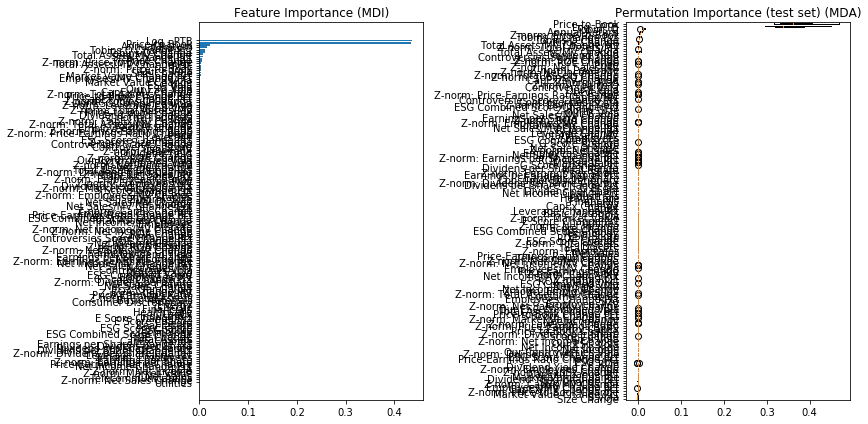

Features sorted by their mean decrease impurity:
[(0.437, 'Log - PTB'), (0.4345, 'Price-to-Book'), (0.0225, 'Annual Return'), (0.0146, 'Tobins Q'), (0.0116, 'Tobins Q Change Pct'), (0.0114, 'Tobins Q Change'), (0.0079, 'Total Assets/MV Change'), (0.0071, 'Size Change Pct'), (0.0059, 'Price Change'), (0.0046, 'Z-norm: Price-to-Book Change'), (0.004, 'Total Assets/MV Change Pct'), (0.0037, 'ROE'), (0.0035, 'Z-norm: Price-to-Book'), (0.003, 'Our E Vola'), (0.0028, 'Size Change'), (0.0028, 'Market Value Change Pct'), (0.0018, 'Employees/MV Change Pct'), (0.0014, 'E Vola'), (0.001, 'Market Value Change'), (0.0009, 'ESG Vola'), (0.0008, 'Z-norm: Total Assets Change'), (0.0008, 'S Vola'), (0.0008, 'Our ESG Vola'), (0.0008, 'CapEx/MV Change'), (0.0007, 'Z-norm: Tobins Q Change'), (0.0007, 'Price-to-Book Change Pct'), (0.0007, 'Our ESG Combined Vola'), (0.0007, 'CapEx/MV Change Pct'), (0.0006, 'Z-norm: Leverage Change'), (0.0005, 'Z-norm: Total Assets/MV'), (0.0005, 'Price-to-Book Change'), (0.

In [55]:
tree1, score1 = reg_tree(train, test, cont_vars , "Log - PTB - next year", ind, 'forest', True)

In [56]:
eval_tree0 = pd.DataFrame.from_dict(tree1.cv_results_)[['mean_test_score', 'params']]

In [57]:
eval_tree0_best = eval_tree0.sort_values(by=['mean_test_score'], ascending=False).head()

In [61]:
eval_tree0_best.iloc[0,1]

{'ccp_alpha': 0.001,
 'max_depth': 15,
 'max_features': 'auto',
 'min_samples_leaf': 10,
 'min_samples_split': 20,
 'n_estimators': 100}

In [104]:
eval_tree0.to_pickle("ptb_forest.pkl")

Fitting 5 folds for each of 1620 candidates, totalling 8100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   44.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 24.1min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 63.1min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 105.5min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 159.2min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 176.6min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 215.2min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 251.5min
[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed: 282.1min
[Parallel(n_jobs=-1)]: Done 6837 tasks      | elapsed: 320.1min
[Parallel(n_jobs=-1)]: Done 7930 tasks      | elapsed: 372.9min
[Parallel(n_jobs=-1)]: Done 8100 out o

Model Performance
Mean Absolute Error: 0.1552
Accuracy = -21.52%.


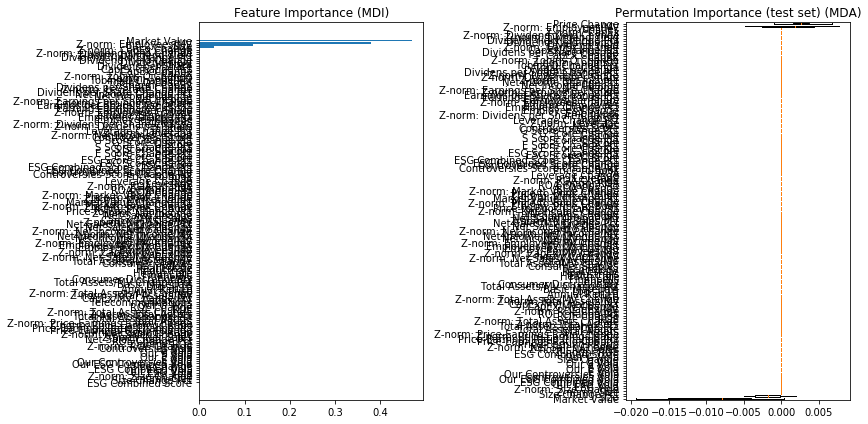

Features sorted by their mean decrease impurity:
[(0.4714, 'Market Value'), (0.3792, 'Z-norm: Employees/MV'), (0.1176, 'Size'), (0.0317, 'Price Change'), (0.0, 'Z-norm: Total Assets/MV Change'), (0.0, 'Z-norm: Total Assets/MV'), (0.0, 'Z-norm: Total Assets Change'), (0.0, 'Z-norm: Total Assets'), (0.0, 'Z-norm: Tobins Q Change'), (0.0, 'Z-norm: Tobins Q'), (0.0, 'Z-norm: Size Change'), (0.0, 'Z-norm: Size'), (0.0, 'Z-norm: ROE Change'), (0.0, 'Z-norm: ROE'), (0.0, 'Z-norm: ROA Change'), (0.0, 'Z-norm: ROA'), (0.0, 'Z-norm: Price-to-Book Change'), (0.0, 'Z-norm: Price-to-Book'), (0.0, 'Z-norm: Price-Earnings Ratio Change'), (0.0, 'Z-norm: Price-Earnings Ratio'), (0.0, 'Z-norm: Net Sales/MV Change'), (0.0, 'Z-norm: Net Sales/MV'), (0.0, 'Z-norm: Net Sales Change'), (0.0, 'Z-norm: Net Sales'), (0.0, 'Z-norm: Net Income/MV Change'), (0.0, 'Z-norm: Net Income/MV'), (0.0, 'Z-norm: Net Income Change'), (0.0, 'Z-norm: Net Income'), (0.0, 'Z-norm: Market Value Change'), (0.0, 'Z-norm: Market Va

In [62]:
tree2, score2 = reg_tree(train, test, cont_vars , "Excess Return - next year", ind, 'forest', True)

In [63]:
eval_tree1 = pd.DataFrame.from_dict(tree2.cv_results_)[['mean_test_score', 'params']]

In [64]:
eval_tree1_best = eval_tree1.sort_values(by=['mean_test_score'], ascending=False).head()

In [65]:
eval_tree1_best.iloc[0,1]

{'ccp_alpha': 0.001,
 'max_depth': 20,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 20,
 'n_estimators': 20}

In [66]:
eval_tree1_best

,mean_test_score,params
439,0.025748,"{'ccp_alpha': 0.001, 'max_depth': 20, 'max_fea..."
246,0.025715,"{'ccp_alpha': 0.001, 'max_depth': 10, 'max_fea..."
355,0.025257,"{'ccp_alpha': 0.001, 'max_depth': 15, 'max_fea..."
338,0.024936,"{'ccp_alpha': 0.001, 'max_depth': 15, 'max_fea..."
230,0.024173,"{'ccp_alpha': 0.001, 'max_depth': 10, 'max_fea..."


In [103]:
eval_tree1.to_pickle("ret_forest.pkl")

Fitting 5 folds for each of 1440 candidates, totalling 7200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 26.1min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 40.0min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 59.4min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 80.9min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 106.7min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 139.0min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 167.2min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 204.3min
[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed: 239.1min
[Parallel(n_jobs=-1)]: Done 6837 tasks      | elapsed: 277.9min
[Parallel(n_jobs=-1)]: Done 7200 out of 7200 | elapsed: 292.3min finished


Model Performance
Mean Absolute Error: 0.1750
Accuracy = 67.93%.


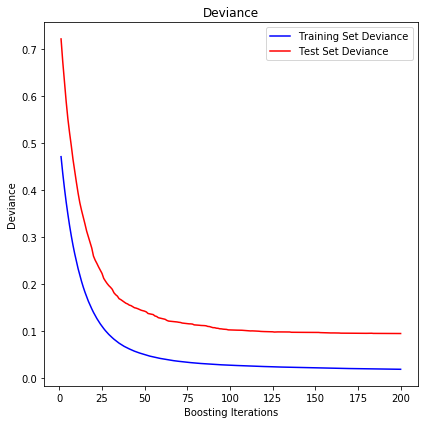

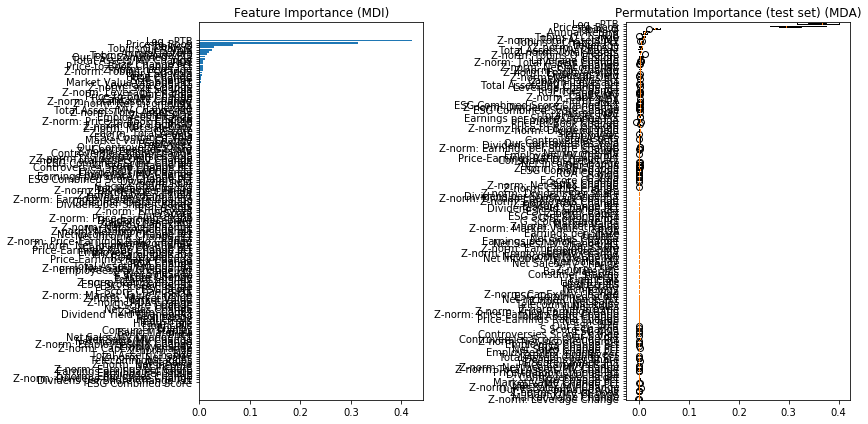

Features sorted by their mean decrease impurity:
[(0.4215, 'Log - PTB'), (0.3147, 'Price-to-Book'), (0.0667, 'Tobins Q'), (0.0281, 'Tobins Q Change'), (0.0241, 'Our S Vola'), (0.0197, 'Annual Return'), (0.0153, 'Tobins Q Change Pct'), (0.0104, 'Our ESG Combined Vola'), (0.0101, 'Total Assets/MV Change'), (0.0076, 'ROE'), (0.0072, 'Size Change Pct'), (0.0069, 'Price-to-Book Change Pct'), (0.0066, 'Z-norm: Leverage'), (0.0064, 'Z-norm: Tobins Q Change'), (0.0053, 'Our ESG Vola'), (0.0048, 'Price Change'), (0.0034, 'ROE Change'), (0.0023, 'Size Change'), (0.0022, 'Market Value Change Pct'), (0.0021, 'Leverage Change'), (0.002, 'Z-norm: Size Change'), (0.002, 'ESG Vola'), (0.0019, 'Z-norm: Leverage Change'), (0.0018, 'Our E Vola'), (0.0017, 'Price-to-Book Change'), (0.0016, 'CapEx/MV Change'), (0.0012, 'Z-norm: Total Assets Change'), (0.0012, 'Z-norm: Net Income/MV'), (0.0012, 'Leverage'), (0.0012, 'E Vola'), (0.0011, 'Total Assets/MV Change Pct'), (0.001, 'Z-norm: Total Assets/MV'), (0.00

In [141]:
tree11, score11 = reg_tree(train, test, cont_vars , "Log - PTB - next year", ind, 'gradboost', True)

In [142]:
eval_tree01 = pd.DataFrame.from_dict(tree11.cv_results_)[['mean_test_score', 'params']]

In [143]:
eval_tree01_best = eval_tree01.sort_values(by=['mean_test_score'], ascending=False).head()

In [144]:
eval_tree01_best.iloc[0,1]

{'learning_rate': 0.05,
 'loss': 'ls',
 'max_depth': 3,
 'min_samples_split': 30,
 'n_estimators': 200}

In [145]:
eval_tree01.to_pickle("ptb_gradboost.pkl")

Fitting 5 folds for each of 1440 candidates, totalling 7200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 25.0min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 40.4min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 62.3min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 85.0min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 112.8min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 145.5min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 173.6min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 216.6min
[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed: 256.8min
[Parallel(n_jobs=-1)]: Done 6837 tasks      | elapsed: 293.9min
[Parallel(n_jobs=-1)]: Done 7200 out of 7200 | elapsed: 308.9min finished


Model Performance
Mean Absolute Error: 0.1567
Accuracy = -93.68%.


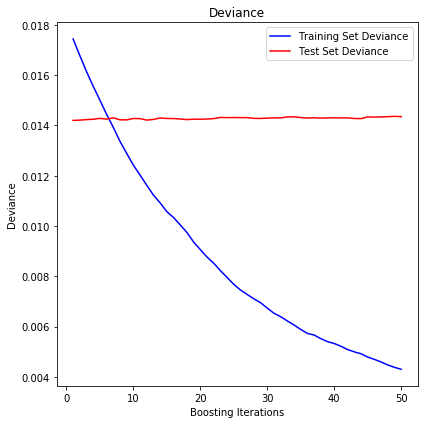

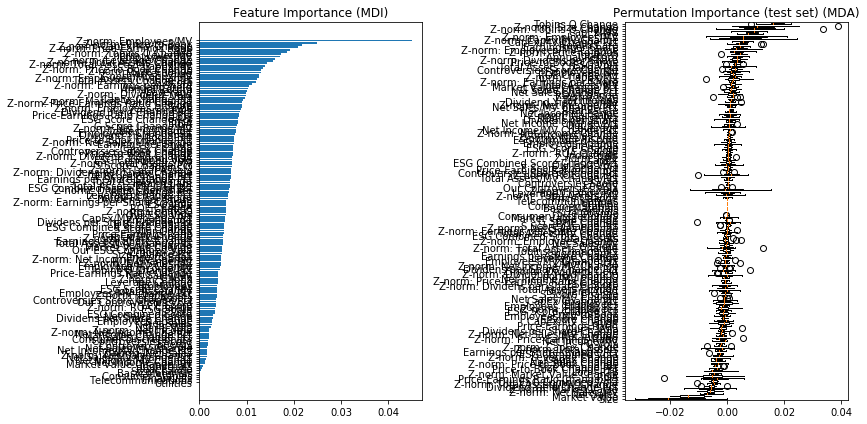

Features sorted by their mean decrease impurity:
[(0.045, 'Z-norm: Employees/MV'), (0.0249, 'Z-norm: Price-to-Book'), (0.0217, 'Z-norm: CapEx/MV Change'), (0.0209, 'Z-norm: Price-Earnings Ratio'), (0.0191, 'Size'), (0.0186, 'Z-norm: Tobins Q Change'), (0.0173, 'Z-norm: Leverage'), (0.017, 'Employees/MV'), (0.0159, 'Z-norm: Leverage Change'), (0.0156, 'Z-norm: Total Assets Change'), (0.0142, 'Z-norm: Total Assets/MV Change'), (0.0138, 'CapEx/MV'), (0.0134, 'Z-norm: Price-to-Book Change'), (0.0131, 'Z-norm: Size Change'), (0.013, 'Market Value'), (0.0127, 'Z-norm: Employees/MV Change'), (0.0127, 'Z-norm: CapEx/MV'), (0.0122, 'Total Assets Change Pct'), (0.012, 'G Score'), (0.0111, 'Z-norm: Earnings per Share'), (0.0105, 'Dividend Yield'), (0.0102, 'Annual Return'), (0.01, 'Leverage'), (0.0098, 'Z-norm: Dividend Yield'), (0.0098, 'Our E Vola'), (0.0097, 'CapEx Change Pct'), (0.0092, 'Z-norm: Market Value Change'), (0.0091, 'Z-norm: Price-Earnings Ratio Change'), (0.0091, 'S Score'), (0.00

In [146]:
tree21, score21 = reg_tree(train, test, cont_vars , "Excess Return - next year", ind, 'gradboost', True)

In [147]:
eval_tree11 = pd.DataFrame.from_dict(tree21.cv_results_)[['mean_test_score', 'params']]

In [148]:
eval_tree11_best = eval_tree11.sort_values(by=['mean_test_score'], ascending=False).head()

In [149]:
eval_tree11_best.iloc[0,1]

{'learning_rate': 0.05,
 'loss': 'huber',
 'max_depth': 9,
 'min_samples_split': 30,
 'n_estimators': 50}

In [150]:
eval_tree11_best

,mean_test_score,params
417,0.092437,"{'learning_rate': 0.05, 'loss': 'huber', 'max_..."
589,0.092242,"{'learning_rate': 0.1, 'loss': 'lad', 'max_dep..."
418,0.089242,"{'learning_rate': 0.05, 'loss': 'huber', 'max_..."
598,0.088619,"{'learning_rate': 0.1, 'loss': 'lad', 'max_dep..."
359,0.088548,"{'learning_rate': 0.05, 'loss': 'lad', 'max_de..."


In [151]:
eval_tree11.to_pickle("ret_gradboost.pkl")

Fitting 5 folds for each of 1080 candidates, totalling 5400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 24.8min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 37.5min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 62.6min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 92.2min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 139.3min
[Parallel(n_jobs=-1)]: Done 5400 out of 5400 | elapsed: 165.4min finished


Model Performance
Mean Absolute Error: 0.1954
Accuracy = 64.76%.


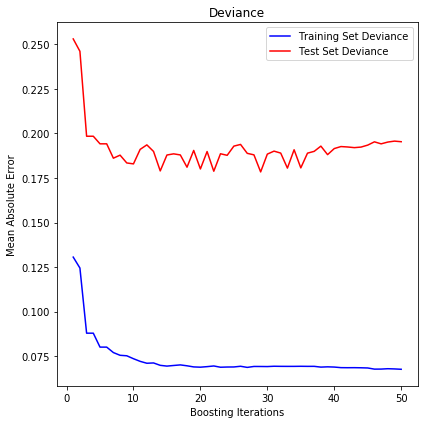

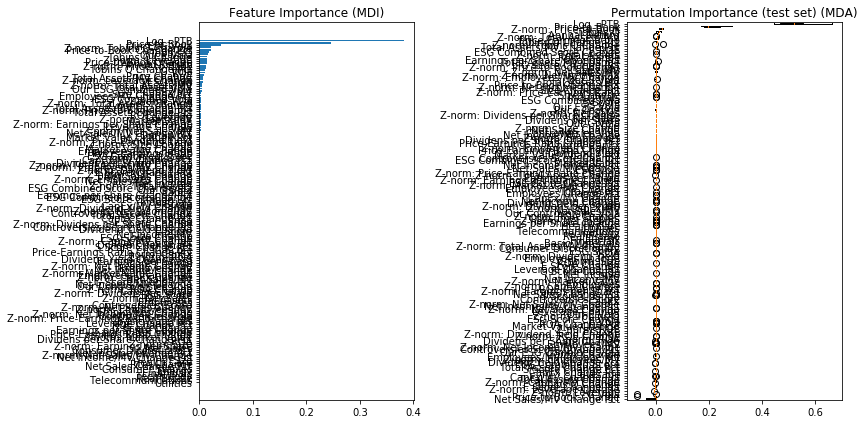

Features sorted by their mean decrease impurity:
[(0.3829, 'Log - PTB'), (0.2452, 'Price-to-Book'), (0.0397, 'Our ESG Vola'), (0.0219, 'Z-norm: Tobins Q Change'), (0.0211, 'Price-to-Book Change Pct'), (0.0172, 'Tobins Q'), (0.0161, 'Our E Vola'), (0.0149, 'Tobins Q Change'), (0.0147, 'Z-norm: Leverage'), (0.0135, 'Price-to-Book Change'), (0.0133, 'Annual Return'), (0.0116, 'Z-norm: Price-to-Book'), (0.0114, 'Tobins Q Change Pct'), (0.0106, 'G Vola'), (0.0102, 'ROE'), (0.0093, 'Price Change'), (0.0075, 'Total Assets/MV Change'), (0.0064, 'Z-norm: Leverage Change'), (0.0061, 'ESG Vola'), (0.0054, 'Z-norm: Total Assets/MV'), (0.0054, 'Total Assets/MV'), (0.0044, 'Our ESG Combined Vola'), (0.004, 'CapEx/MV'), (0.0038, 'Size Change Pct'), (0.0035, 'Employees/MV Change Pct'), (0.0035, 'ESG Combined Vola'), (0.0032, 'Z-norm: ROE'), (0.0031, 'Z-norm: Total Assets Change'), (0.0031, 'Z-norm: Tobins Q'), (0.003, 'Total Assets/MV Change Pct'), (0.0029, 'Z-norm: Price-to-Book Change'), (0.0028, 'Z

In [152]:
tree12, score12 = reg_tree(train, test, cont_vars , "Log - PTB - next year", ind, 'adaboost', True)

In [153]:
eval_tree02 = pd.DataFrame.from_dict(tree12.cv_results_)[['mean_test_score', 'params']]

In [154]:
eval_tree02_best = eval_tree02.sort_values(by=['mean_test_score'], ascending=False).head()

In [155]:
eval_tree02_best.iloc[0,1]

{'base_estimator__max_depth': 9,
 'base_estimator__min_samples_split': 10,
 'learning_rate': 0.3,
 'loss': 'square',
 'n_estimators': 50}

In [156]:
eval_tree02.to_pickle("ptb_adaboost.pkl")

Fitting 5 folds for each of 1080 candidates, totalling 5400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 25.2min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 40.2min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 69.4min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 103.8min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 159.3min
[Parallel(n_jobs=-1)]: Done 5400 out of 5400 | elapsed: 192.0min finished


Model Performance
Mean Absolute Error: 0.1541
Accuracy = -70.60%.


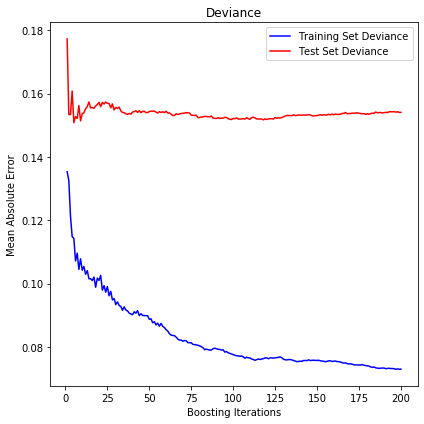

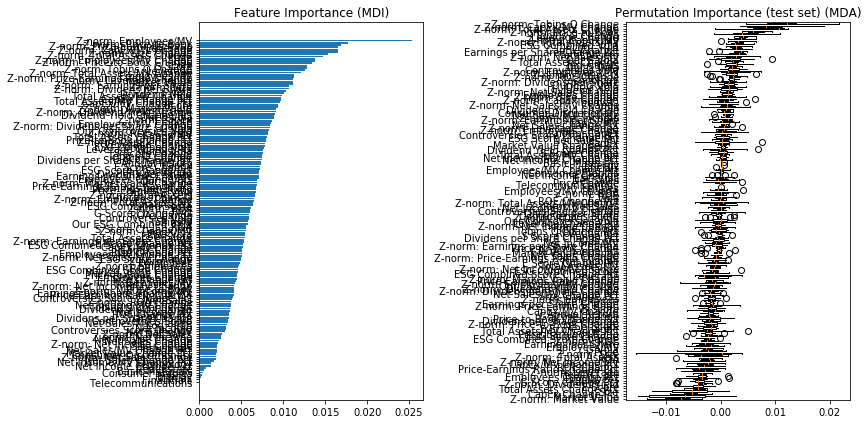

Features sorted by their mean decrease impurity:
[(0.0254, 'Z-norm: Employees/MV'), (0.0177, 'Z-norm: Price-to-Book'), (0.0168, 'Z-norm: Price-Earnings Ratio'), (0.0166, 'Z-norm: Leverage'), (0.0165, 'Z-norm: Size Change'), (0.0165, 'Z-norm: CapEx/MV Change'), (0.0154, 'Z-norm: Total Assets Change'), (0.0147, 'Price'), (0.0138, 'Z-norm: Price-to-Book Change'), (0.0138, 'Z-norm: Employees/MV Change'), (0.0134, 'Size'), (0.0129, 'G Score'), (0.0128, 'Z-norm: Tobins Q Change'), (0.0126, 'Leverage'), (0.0122, 'Z-norm: Total Assets/MV Change'), (0.0113, 'Employees/MV'), (0.0112, 'Z-norm: Price-Earnings Ratio Change'), (0.0111, 'Z-norm: Leverage Change'), (0.0111, 'Z-norm: Earnings per Share'), (0.0111, 'Market Value'), (0.0107, 'Z-norm: Size'), (0.0107, 'Z-norm: Dividens per Share'), (0.0103, 'S Vola'), (0.0101, 'Dividend Yield'), (0.0099, 'Total Assets/MV Change'), (0.0097, 'Total Assets/MV Change Pct'), (0.0097, 'CapEx Change Pct'), (0.0096, 'CapEx/MV Change Pct'), (0.0094, 'S Score'), (0

In [157]:
tree22, score22 = reg_tree(train, test, cont_vars , "Excess Return - next year", ind, 'adaboost', True)

In [158]:
eval_tree12 = pd.DataFrame.from_dict(tree22.cv_results_)[['mean_test_score', 'params']]

In [159]:
eval_tree12_best = eval_tree12.sort_values(by=['mean_test_score'], ascending=False).head()

In [160]:
eval_tree12_best.iloc[0,1]

{'base_estimator__max_depth': 9,
 'base_estimator__min_samples_split': 10,
 'learning_rate': 0.3,
 'loss': 'exponential',
 'n_estimators': 200}

In [161]:
eval_tree12_best

,mean_test_score,params
869,0.088663,"{'base_estimator__max_depth': 9, 'base_estimat..."
974,0.086667,"{'base_estimator__max_depth': 9, 'base_estimat..."
854,0.085278,"{'base_estimator__max_depth': 9, 'base_estimat..."
889,0.085125,"{'base_estimator__max_depth': 9, 'base_estimat..."
858,0.085035,"{'base_estimator__max_depth': 9, 'base_estimat..."


In [162]:
eval_tree12.to_pickle("ret_adaboost.pkl")

# Classification

In [69]:
data['Up'] = np.where(data['Excess Return']>=0, 1, 0)

In [70]:
data['Up - next year'] = np.where(data['Excess Return - next year']>=0, 1, 0)

In [71]:
conditions = [
    (data['Excess Return Percentile'].isna()),
    (data['Excess Return Percentile'] <= 0.1),
    (data['Excess Return Percentile'] > 0.1) & (data['Excess Return Percentile']  <= 0.2),
    (data['Excess Return Percentile'] > 0.2) & (data['Excess Return Percentile']  <= 0.3),
    (data['Excess Return Percentile'] > 0.3) & (data['Excess Return Percentile']  <= 0.4),
    (data['Excess Return Percentile'] > 0.4) & (data['Excess Return Percentile']  <= 0.5),
    (data['Excess Return Percentile'] > 0.5) & (data['Excess Return Percentile']  <= 0.6),
    (data['Excess Return Percentile'] > 0.6) & (data['Excess Return Percentile']  <= 0.7),
    (data['Excess Return Percentile'] > 0.7) & (data['Excess Return Percentile']  <= 0.8),
    (data['Excess Return Percentile'] > 0.8) & (data['Excess Return Percentile']  <= 0.9),
    (data['Excess Return Percentile'] > 0.9)
    ]

# create a list of the values we want to assign for each condition
values = [np.nan, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# create a new column and use np.select to assign values to it using our lists as arguments
data['Excess Return - Deciles'] = np.select(conditions, values)

In [72]:
conditions = [
    (data['Excess Return Percentile - next year'].isna()),
    (data['Excess Return Percentile - next year'] <= 0.1),
    (data['Excess Return Percentile - next year'] > 0.1) & (data['Excess Return Percentile - next year']  <= 0.2),
    (data['Excess Return Percentile - next year'] > 0.2) & (data['Excess Return Percentile - next year']  <= 0.3),
    (data['Excess Return Percentile - next year'] > 0.3) & (data['Excess Return Percentile - next year']  <= 0.4),
    (data['Excess Return Percentile - next year'] > 0.4) & (data['Excess Return Percentile - next year']  <= 0.5),
    (data['Excess Return Percentile - next year'] > 0.5) & (data['Excess Return Percentile - next year']  <= 0.6),
    (data['Excess Return Percentile - next year'] > 0.6) & (data['Excess Return Percentile - next year']  <= 0.7),
    (data['Excess Return Percentile - next year'] > 0.7) & (data['Excess Return Percentile - next year']  <= 0.8),
    (data['Excess Return Percentile - next year'] > 0.8) & (data['Excess Return Percentile - next year']  <= 0.9),
    (data['Excess Return Percentile - next year'] > 0.9)
    ]

# create a list of the values we want to assign for each condition
values = [np.nan, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# create a new column and use np.select to assign values to it using our lists as arguments
data['Excess Return - Deciles - next year'] = np.select(conditions, values)

In [73]:
cont_vars_class = cont_vars.copy()

In [74]:
cont_vars_class.extend(['Up', 'Excess Return - Deciles'])

In [76]:
train = data[data['Time'] < 2018]
test = data[data['Time'] == 2018]
holdout = data[data['Time'] == 2019]

Fitting 5 folds for each of 1620 candidates, totalling 8100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   49.2s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 18.3min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 25.8min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 30.3min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 37.6min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 49.2min
[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed: 57.7min
[Parallel(n_jobs=-1)]: Done 6837 tasks      | elapsed: 66.2min
[Parallel(n_jobs=-1)]: Done 7930 tasks      | elapsed: 78.6min
[Parallel(n_jobs=-1)]: Done 8100 out of 8100 |

Model Performance
Mean Absolute Error: 0.4274
Accuracy = nan%.
Accuracy Score = 0.5726


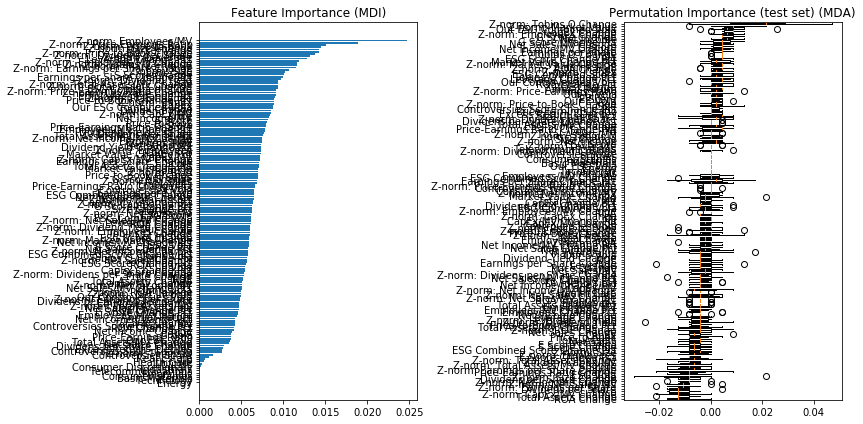

Features sorted by their mean decrease impurity:
[(0.0247, 'Z-norm: Employees/MV'), (0.0189, 'Z-norm: Price-Earnings Ratio'), (0.0151, 'Z-norm: Price-to-Book'), (0.0144, 'Z-norm: Size Change'), (0.0142, 'Z-norm: Price-to-Book Change'), (0.0142, 'Market Value'), (0.0137, 'Z-norm: Dividens per Share'), (0.0131, 'Z-norm: Leverage'), (0.0128, 'Leverage Change Pct'), (0.0119, 'Z-norm: Employees/MV Change'), (0.0116, 'Z-norm: Tobins Q Change'), (0.0116, 'Z-norm: Market Value'), (0.0115, 'Z-norm: Earnings per Share Change'), (0.0107, 'Z-norm: Size'), (0.0102, 'Leverage'), (0.0101, 'S Score Change'), (0.0099, 'Earnings per Share Change Pct'), (0.0097, 'Z-norm: Dividend Yield'), (0.0094, 'Z-norm: Total Assets/MV Change'), (0.0094, 'Size'), (0.0093, 'Z-norm: Total Assets Change'), (0.0093, 'ESG Combined Score'), (0.0092, 'Z-norm: Price-Earnings Ratio Change'), (0.0091, 'Z-norm: Leverage Change'), (0.0091, 'Employees Change Pct'), (0.009, 'Z-norm: ROE Change'), (0.0089, 'Z-norm: CapEx'), (0.0089,

In [99]:
tree3, score3 = reg_tree(train, test, cont_vars_class , "Up - next year", ind, 'forest class', True)

In [105]:
eval_tree2 = pd.DataFrame.from_dict(tree3.cv_results_)[['mean_test_score', 'params']]

In [106]:
eval_tree2_best = eval_tree2.sort_values(by=['mean_test_score'], ascending=False).head()

In [107]:
eval_tree2_best.iloc[0,1]

{'ccp_alpha': 0.001,
 'max_depth': 15,
 'max_features': 'sqrt',
 'min_samples_leaf': 10,
 'min_samples_split': 10,
 'n_estimators': 50}

In [108]:
eval_tree2.to_pickle("up_forest.pkl")

Fitting 5 folds for each of 1620 candidates, totalling 8100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   57.6s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 22.2min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 31.8min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 37.2min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 44.3min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 55.2min
[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed: 63.6min
[Parallel(n_jobs=-1)]: Done 6837 tasks      | elapsed: 75.0min
[Parallel(n_jobs=-1)]: Done 7930 tasks      | elapsed: 92.1min
[Parallel(n_jobs=-1)]: Done 8100 out of 8100 |

Model Performance
Mean Absolute Error: 2.5427
Accuracy = nan%.
Accuracy Score = 0.1111


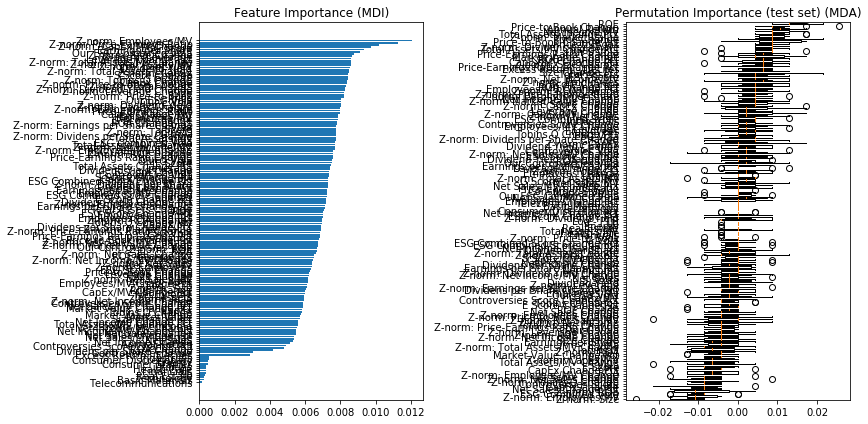

Features sorted by their mean decrease impurity:
[(0.0121, 'Z-norm: Employees/MV'), (0.0113, 'Z-norm: Price-Earnings Ratio'), (0.0102, 'Z-norm: CapEx/MV Change'), (0.0098, 'ESG Score'), (0.0093, 'Earnings per Share'), (0.0091, 'Our ESG Combined Vola'), (0.0088, 'Z-norm: Size Change'), (0.0087, 'Z-norm: Leverage'), (0.0086, 'Z-norm: Total Assets/MV Change'), (0.0086, 'Z-norm: Total Assets/MV'), (0.0086, 'Z-norm: CapEx/MV'), (0.0086, 'Leverage Change Pct'), (0.0085, 'Z-norm: Total Assets Change'), (0.0085, 'Z-norm: CapEx'), (0.0085, 'S Score Change'), (0.0085, 'Dividend Yield'), (0.0084, 'Z-norm: Tobins Q Change'), (0.0084, 'Z-norm: Price-to-Book Change'), (0.0084, 'G Score'), (0.0084, 'CapEx Change'), (0.0083, 'Z-norm: Total Assets'), (0.0083, 'Z-norm: Leverage Change'), (0.0083, 'Z-norm: Dividend Yield Change'), (0.0082, 'Z-norm: Price-to-Book'), (0.0082, 'Size'), (0.0082, 'Price'), (0.008, 'Z-norm: Earnings per Share'), (0.008, 'Z-norm: Dividend Yield'), (0.008, 'Z-norm: CapEx Change'

In [100]:
tree4, score4 = reg_tree(train, test, cont_vars_class , "Excess Return - Deciles - next year", ind, 'forest class', True)

In [109]:
eval_tree3 = pd.DataFrame.from_dict(tree4.cv_results_)[['mean_test_score', 'params']]

In [110]:
eval_tree3_best = eval_tree3.sort_values(by=['mean_test_score'], ascending=False).head()

In [111]:
eval_tree3_best.iloc[0,1]

{'ccp_alpha': 0.001,
 'max_depth': 20,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 20,
 'n_estimators': 200}

In [112]:
eval_tree3.to_pickle("decile_ret_forest.pkl")

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 25.9min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 38.9min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 57.6min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 77.2min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 97.7min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 118.8min
[Parallel(n_jobs=-1)]: Done 3600 out of 3600 | elapsed: 128.0min finished
/Users/vanessatheel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/Users/vanessatheel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning

Model Performance
Mean Absolute Error: 0.4872
Accuracy = nan%.
Accuracy Score = 0.5128


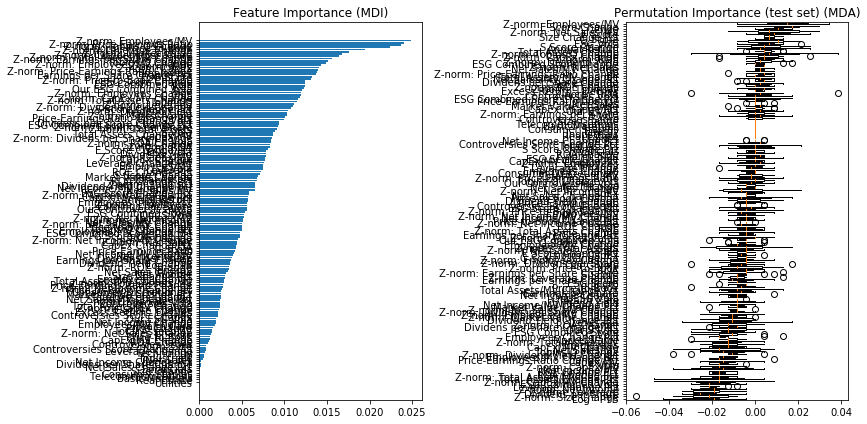

Features sorted by their mean decrease impurity:
[(0.0249, 'Z-norm: Employees/MV'), (0.0241, 'Z-norm: Price-Earnings Ratio'), (0.0237, 'Z-norm: Tobins Q Change'), (0.0224, 'Z-norm: Price-to-Book'), (0.0195, 'Z-norm: Leverage Change'), (0.0176, 'Z-norm: Market Value'), (0.0168, 'Z-norm: Dividens per Share'), (0.0164, 'Z-norm: Total Assets/MV Change'), (0.0155, 'Z-norm: Earnings per Share Change'), (0.0151, 'Tobins Q Change'), (0.0148, 'Z-norm: Employees/MV Change'), (0.0143, 'Z-norm: ROE'), (0.0141, 'Z-norm: CapEx'), (0.014, 'Z-norm: Price-Earnings Ratio Change'), (0.0138, 'Employees'), (0.0137, 'Earnings per Share Change Pct'), (0.0132, 'ESG Score'), (0.0131, 'Z-norm: Price-to-Book Change'), (0.0124, 'ROE'), (0.0124, 'ESG Score Change'), (0.0124, 'ESG Combined Vola'), (0.0123, 'Our ESG Combined Vola'), (0.0121, 'Size'), (0.0119, 'Z-norm: Employees Change'), (0.0119, 'G Vola'), (0.0118, 'Z-norm: CapEx/MV Change'), (0.0116, 'Z-norm: Total Assets Change'), (0.0115, 'Tobins Q'), (0.0111, '

In [101]:
tree5, score5 = reg_tree(train, test, cont_vars_class , "Up - next year", ind, 'gradboost class', True)

In [116]:
eval_tree4 = pd.DataFrame.from_dict(tree5.cv_results_)[['mean_test_score', 'params']]

In [117]:
eval_tree4_best = eval_tree4.sort_values(by=['mean_test_score'], ascending=False).head()

In [118]:
eval_tree4_best.iloc[0,1]

{'learning_rate': 0.5,
 'loss': 'exponential',
 'max_depth': 9,
 'min_samples_split': 10,
 'n_estimators': 50}

In [119]:
eval_tree4.to_pickle("up_gradboost.pkl")

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 27.5min
[Parallel(n_jobs=-1)]: Done 377 tasks      | elapsed: 122.5min
[Parallel(n_jobs=-1)]: Done 840 tasks      | elapsed: 198.0min
[Parallel(n_jobs=-1)]: Done 1405 tasks      | elapsed: 305.2min
[Parallel(n_jobs=-1)]: Done 2062 tasks      | elapsed: 440.9min
[Parallel(n_jobs=-1)]: Done 3050 tasks      | elapsed: 537.7min
[Parallel(n_jobs=-1)]: Done 3600 out of 3600 | elapsed: 711.3min finished
/Users/vanessatheel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/Users/vanessatheel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


Model Performance
Mean Absolute Error: 2.8547
Accuracy = nan%.
Accuracy Score = 0.1538


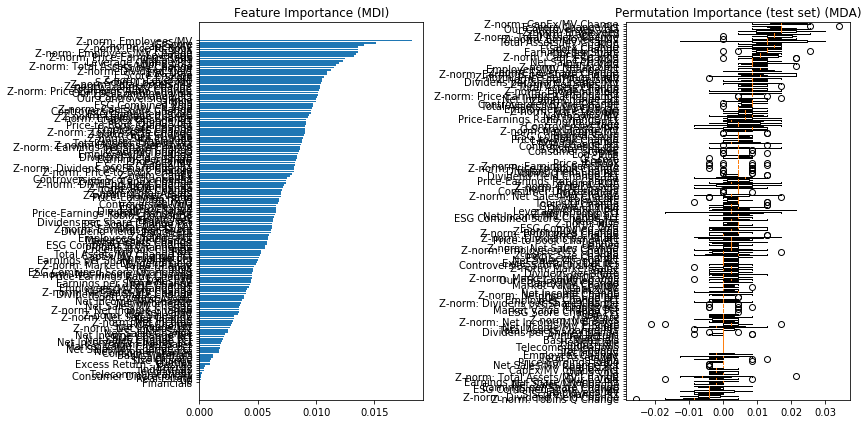

Features sorted by their mean decrease impurity:
[(0.0183, 'Z-norm: Employees/MV'), (0.0151, 'G Score'), (0.0141, 'Z-norm: CapEx/MV'), (0.0136, 'Z-norm: Price-to-Book'), (0.0136, 'Z-norm: Employees/MV Change'), (0.0136, 'S Vola'), (0.0134, 'Leverage'), (0.0132, 'Z-norm: Price-Earnings Ratio'), (0.0125, 'Our S Vola'), (0.0123, 'Leverage Change Pct'), (0.0119, 'Our E Vola'), (0.0117, 'Z-norm: Total Assets/MV Change'), (0.0116, 'G Score Change'), (0.0113, 'Z-norm: Dividend Yield'), (0.0109, 'ESG Vola'), (0.0109, 'E Score Change'), (0.0106, 'Z-norm: Leverage'), (0.0106, 'E Score'), (0.0105, 'S Score Change Pct'), (0.0104, 'Z-norm: Total Assets/MV'), (0.0103, 'Z-norm: Tobins Q Change'), (0.0103, 'Total Assets/MV Change'), (0.0102, 'Z-norm: Price-Earnings Ratio Change'), (0.0102, 'Our ESG Combined Vola'), (0.0102, 'G Score Change Pct'), (0.0101, 'Our Controversies Vola'), (0.01, 'Price'), (0.01, 'G Vola'), (0.0098, 'ESG Combined Vola'), (0.0098, 'E Vola'), (0.0096, 'Z-norm: CapEx/MV Change')

In [102]:
tree6, score6 = reg_tree(train, test, cont_vars_class , "Excess Return - Deciles - next year", ind, 'gradboost class', True)

In [120]:
eval_tree5 = pd.DataFrame.from_dict(tree6.cv_results_)[['mean_test_score', 'params']]

In [121]:
eval_tree5_best = eval_tree5.sort_values(by=['mean_test_score'], ascending=False).head()

In [122]:
eval_tree5_best.iloc[0,1]

{'learning_rate': 0.05,
 'loss': 'deviance',
 'max_depth': 9,
 'min_samples_split': 20,
 'n_estimators': 50}

In [123]:
eval_tree5.to_pickle("decile_ret_gradboost.pkl")

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 28.3min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 56.6min
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed: 84.1min finished
/Users/vanessatheel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/Users/vanessatheel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


Model Performance
Mean Absolute Error: 0.4402
Accuracy = nan%.
Accuracy Score = 0.5598


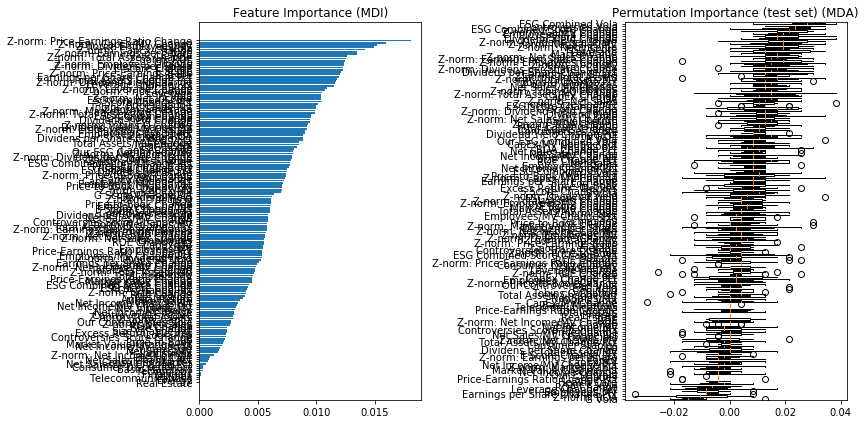

Features sorted by their mean decrease impurity:
[(0.0181, 'Z-norm: Price-Earnings Ratio Change'), (0.016, 'Z-norm: CapEx/MV Change'), (0.0152, 'Z-norm: Employees/MV'), (0.015, 'G Vola'), (0.0142, 'Z-norm: CapEx Change'), (0.0135, 'Z-norm: Earnings per Share'), (0.0134, 'E Vola'), (0.0126, 'Z-norm: Total Assets Change'), (0.0125, 'Z-norm: ROE'), (0.0125, 'G Score'), (0.0124, 'Z-norm: Employees Change'), (0.0124, 'Z-norm: Dividens per Share'), (0.0123, 'E Score Change'), (0.0123, 'E Score'), (0.0121, 'Z-norm: Price-Earnings Ratio'), (0.0121, 'S Score'), (0.012, 'Earnings per Share Change Pct'), (0.0118, 'Total Assets Change Pct'), (0.0117, 'Z-norm: Dividend Yield Change'), (0.0116, 'Leverage Change Pct'), (0.0115, 'Our E Vola'), (0.0109, 'Z-norm: Leverage Change'), (0.0108, 'Z-norm: Price-to-Book'), (0.0105, 'Leverage'), (0.0104, 'Z-norm: Net Income'), (0.0104, 'S Vola'), (0.0104, 'S Score Change Pct'), (0.0104, 'ESG Combined Score'), (0.0101, 'Price Change'), (0.01, 'Z-norm: Leverage')

In [129]:
tree7, score7 = reg_tree(train, test, cont_vars_class , "Up - next year", ind, 'adaboost class', True)

In [131]:
eval_tree6 = pd.DataFrame.from_dict(tree7.cv_results_)[['mean_test_score', 'params']]

In [132]:
eval_tree6_best = eval_tree6.sort_values(by=['mean_test_score'], ascending=False).head()

In [133]:
eval_tree6_best.iloc[0,1]

{'base_estimator__max_depth': 9,
 'base_estimator__min_samples_split': 20,
 'learning_rate': 1,
 'n_estimators': 200}

In [134]:
eval_tree6.to_pickle("up_adaboost.pkl")

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 28.6min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 60.8min
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed: 93.2min finished
/Users/vanessatheel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


Model Performance
Mean Absolute Error: 2.7650
Accuracy = -inf%.
Accuracy Score = 0.0983


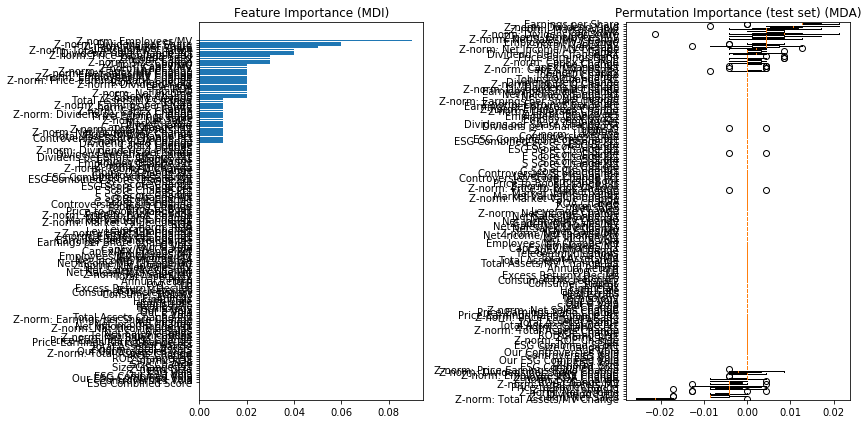

Features sorted by their mean decrease impurity:
[(0.09, 'Z-norm: Employees/MV'), (0.06, 'Z-norm: Market Value'), (0.06, 'Z-norm: Dividens per Share'), (0.05, 'Earnings per Share'), (0.04, 'Z-norm: Total Assets/MV Change'), (0.04, 'Z-norm: Price-Earnings Ratio'), (0.04, 'Dividend Yield Change Pct'), (0.03, 'Z-norm: Tobins Q'), (0.03, 'Z-norm: Size Change'), (0.03, 'Z-norm: CapEx'), (0.03, 'Dividend Yield'), (0.02, 'Z-norm: Price-Earnings Ratio Change'), (0.02, 'Z-norm: Net Sales/MV Change'), (0.02, 'Z-norm: Net Income'), (0.02, 'Z-norm: Leverage'), (0.02, 'Z-norm: Employees/MV Change'), (0.02, 'Z-norm: Dividend Yield'), (0.02, 'Z-norm: CapEx/MV Change'), (0.02, 'Z-norm: CapEx/MV'), (0.02, 'Tobins Q'), (0.02, 'ROE'), (0.02, 'ROA Change Pct'), (0.02, 'Leverage'), (0.02, 'Employees/MV Change'), (0.02, 'E Score Change'), (0.02, 'CapEx/MV'), (0.01, 'Z-norm: Total Assets/MV'), (0.01, 'Z-norm: ROE Change'), (0.01, 'Z-norm: ROA Change'), (0.01, 'Z-norm: Net Sales'), (0.01, 'Z-norm: Net Income/

In [130]:
tree8, score8 = reg_tree(train, test, cont_vars_class , "Excess Return - Deciles - next year", ind, 'adaboost class', True)

In [135]:
eval_tree7 = pd.DataFrame.from_dict(tree8.cv_results_)[['mean_test_score', 'params']]

In [136]:
eval_tree7_best = eval_tree7.sort_values(by=['mean_test_score'], ascending=False).head()

In [137]:
eval_tree7_best.iloc[0,1]

{'base_estimator__max_depth': 1,
 'base_estimator__min_samples_split': 30,
 'learning_rate': 0.1,
 'n_estimators': 100}

In [138]:
eval_tree7.to_pickle("decile_ret_adaboost.pkl")